# _Skin Cancer Image Classification: Nov. 27, 2019_

This notebooks builds on the work don in `nov26-skin-cancer.ipynb`. Below are the current modifications implemented:
- Data Augmentation (flip vertical/horizontal, rotation, dihedral)
- [Ranger optimizer](https://medium.com/@lessw/new-deep-learning-optimizer-ranger-synergistic-combination-of-radam-lookahead-for-the-best-of-2dc83f79a48d)

Including ranger had a significant impact on performance, as assessed via the accuracy on the validation set. Without ranger, the model was able to achieve about ~82% accuracy; with ranger, it got up a little past 88%. Additionally, it did a better job of distinguishing between melanocytic nevi and melanoma (albeit there still is room for improvement). 

Today, I will test to see if we can improve the model performance even further by using:
- `xresnet50` --> need to look this up further to accurately distinguish the differences between it and `resnet50`
- increase `max_rotate` data augmentation from `25` to `50`
- implement Mish activation function (as opposed to ReLU)

In [0]:
# mount your Google Drive, giving us access to any files we have stored there
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [0]:
# import deep learning libraries
import torch
import fastai
from fastai import *
from fastai.vision import *

In [0]:
# import os library to better help us navigate directories (which in this) case is our Google Drive
import os

# what is our current working directory?
print("Our current working directory is '{}'.".format(os.getcwd()))

Our current working directory is '/content'.


In [0]:
# change our directory to the one associated with this project
os.chdir('/content/gdrive/My Drive/projects/skin-cancer')

# lets confirm that it updated the directory accordingly
os.getcwd()

'/content/gdrive/My Drive/projects/skin-cancer'

# _Create DataFrame_

In [0]:
from pathlib import Path

#create path variable to primary directory
path = Path(os.getcwd())
path

PosixPath('/content/gdrive/My Drive/projects/skin-cancer')

In [0]:
import pandas as pd

df = pd.read_csv(path/'skin-data/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [0]:
diagnosis_dict = {
    'akiec': 'Actinic keratoses', # potential pre-cancer
    'bcc': 'Basal cell carcinoma', # not so good
    'bkl': 'Benign keratosis', # benign is good
    'df': 'Dermatofibroma', # benign
    'mel': 'Melanoma', # very bad
    'nv': 'Melanocytic nevi', # common mole
    'vasc': 'Vascular lesions' # could be benign or malignant
    }

In [0]:
# create a new column with a more specific diagnosis (better able to understand diagnosis)
df['diagnosis'] = df['dx'].map(diagnosis_dict).astype('category')

In [0]:
df['diagnosis'].value_counts(normalize=True)

Melanocytic nevi        0.669496
Melanoma                0.111133
Benign keratosis        0.109735
Basal cell carcinoma    0.051323
Actinic keratoses       0.032651
Vascular lesions        0.014179
Dermatofibroma          0.011483
Name: diagnosis, dtype: float64

# _Data Augmentation_

In [0]:
tfms = get_transforms(do_flip=True, 
                      flip_vert=True,
                      max_rotate=50, # update to max_rotate 25 --> 50
                      max_zoom=1.0,
                      xtra_tfms=dihedral())

# _Create `data` object_

In [0]:
data = ImageDataBunch.from_df(
    path=path/'skin-data/HAM10000_images_part_1',
    df=df, # take from full dataframe with only relevant information
    valid_pct=0.2, 
    seed=1, 
    fn_col='image_id',
    label_col='diagnosis', 
    suffix='.jpg', 
    ds_tfms=tfms, 
    size=224,
    bs=32
)

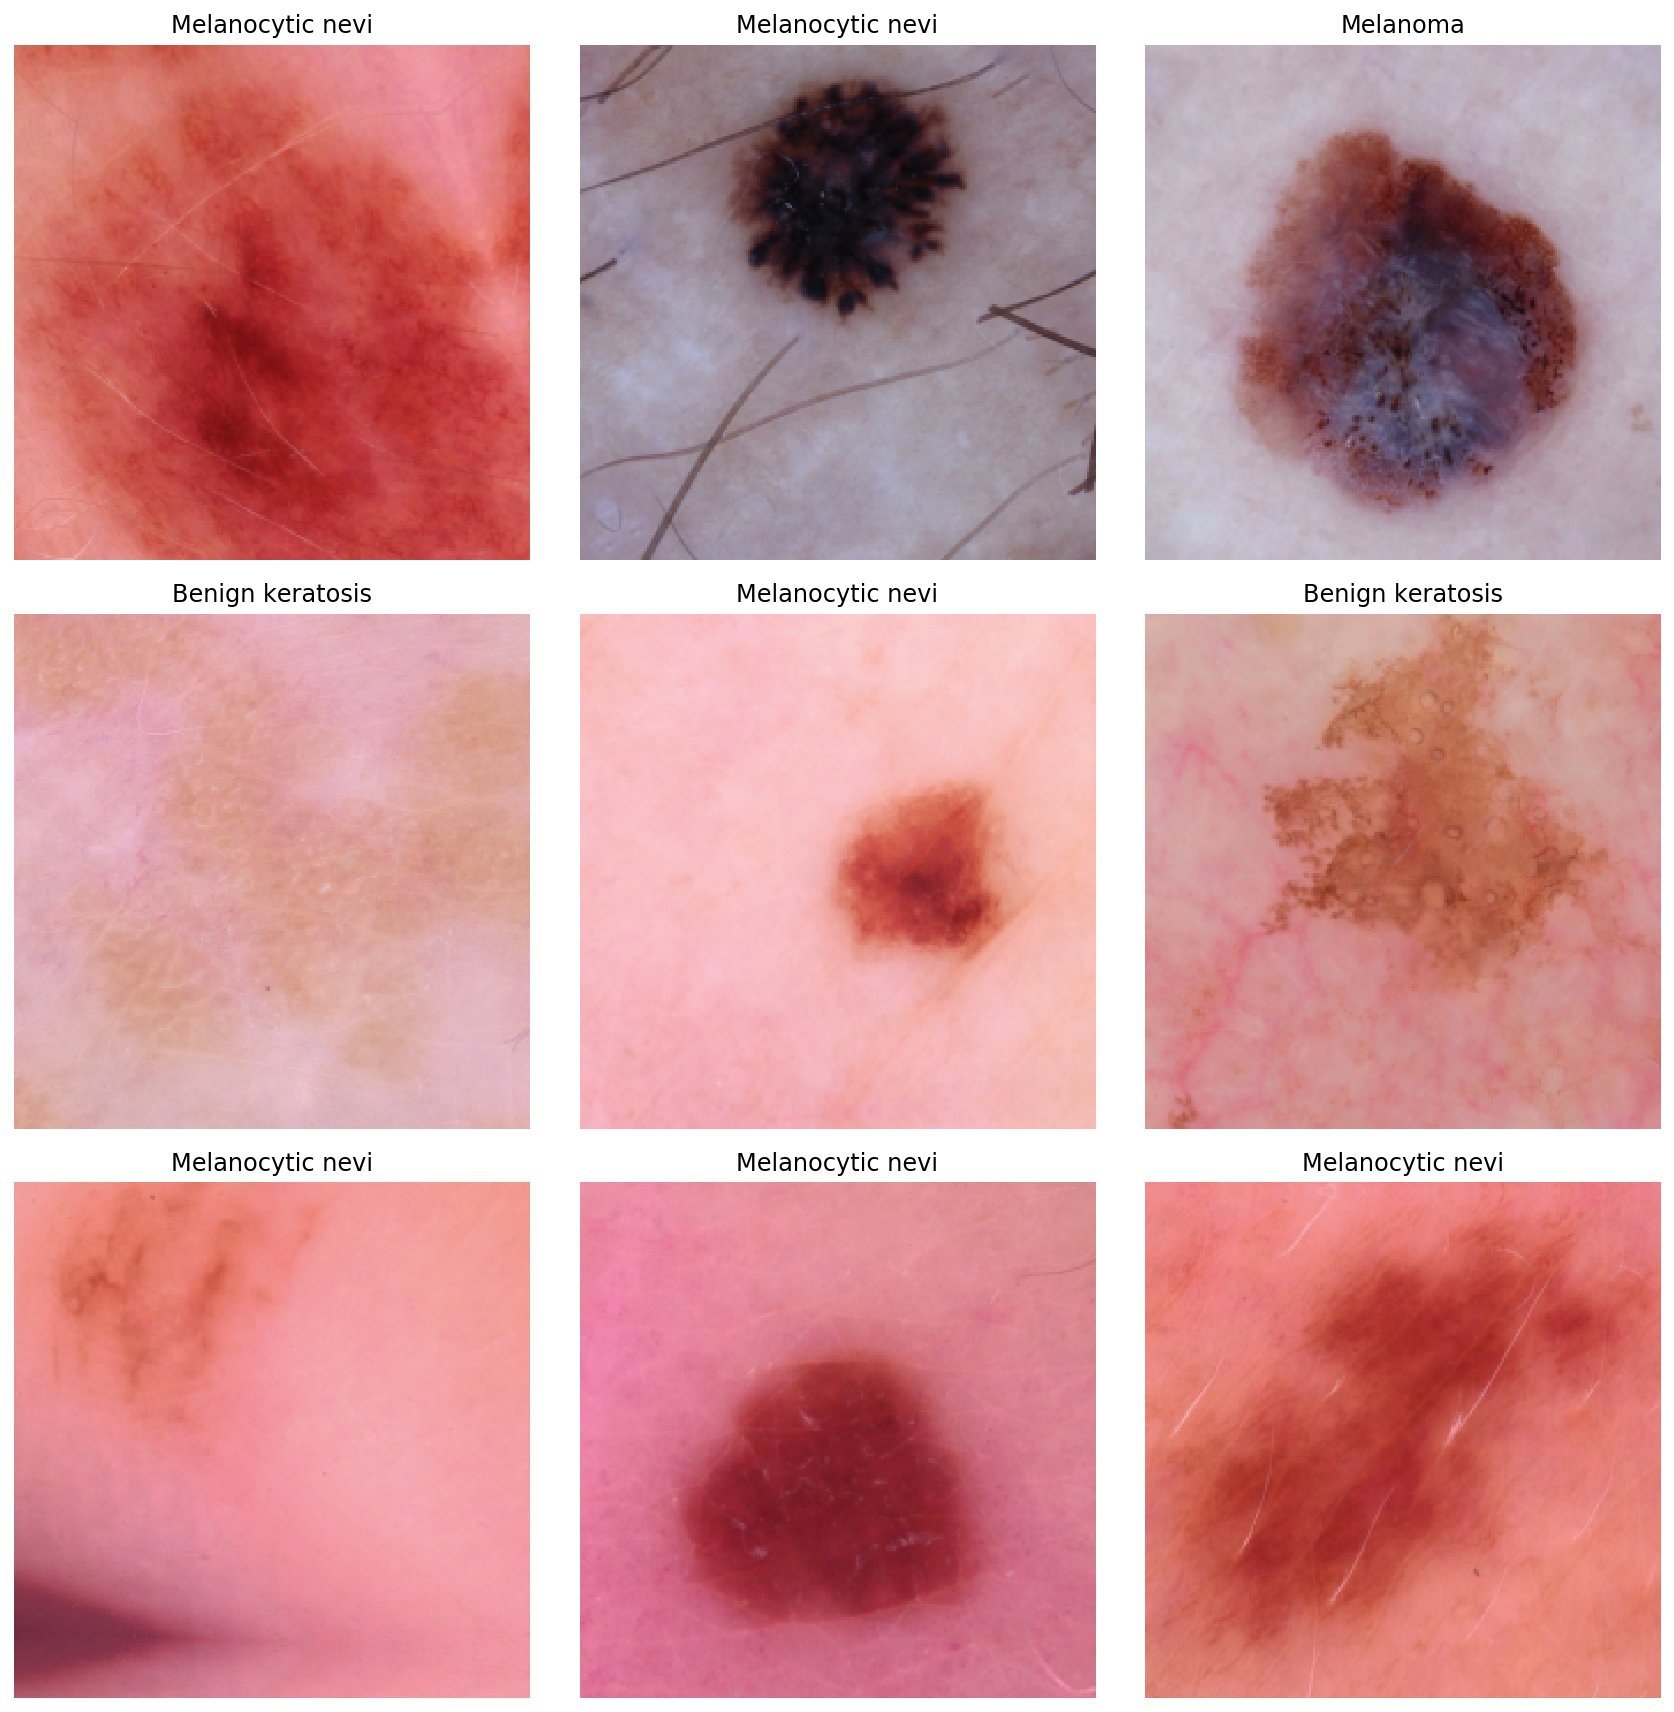

In [0]:
data.show_batch(rows=3)

In [0]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (8012 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Benign keratosis,Benign keratosis,Benign keratosis,Benign keratosis,Benign keratosis
Path: /content/gdrive/My Drive/projects/skin-cancer/skin-data/HAM10000_images_part_1;

Valid: LabelList (2003 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Melanocytic nevi,Melanocytic nevi,Melanocytic nevi,Melanocytic nevi,Basal cell carcinoma
Path: /content/gdrive/My Drive/projects/skin-cancer/skin-data/HAM10000_images_part_1;

Test: None

# _Implement Ranger_

In [0]:
from joetools import ranger

# create Ranger object
optar = partial(ranger.Ranger)
optar

functools.partial(<class 'joetools.ranger.Ranger'>)

# _Implement Mish_

In [0]:
import torch.nn as nn
import torch.nn.functional as F  #(uncomment if needed,but you likely already have it)

#Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
#https://arxiv.org/abs/1908.08681v1
#implemented for PyTorch / FastAI by lessw2020 
#github: https://github.com/lessw2020/mish

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [0]:
def mish_resnet():
    model = models.resnet50
    model._fc = Mish
    return model

In [0]:
# create xresnet50 object
model = mish_resnet()

# _Create Learner_

In [0]:
f1 = FBeta()
f1.beta = 1
f1.average = 'macro'

In [0]:
learn = cnn_learner(
    data,
    model,
    metrics=[accuracy, f1],
    loss_func=LabelSmoothingCrossEntropy(),
    opt_func=optar,
    bn_wd=False,
    true_wd=True,
    path=path
)

In [0]:
# load weights from training on sample
learn.load('starting_sample');

set state called


In [0]:
# workaround to allow for training (need to address the underlying issue)
learn.unfreeze()

# _Training Run 1_

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-05
Min loss divided by 10: 2.29E-03


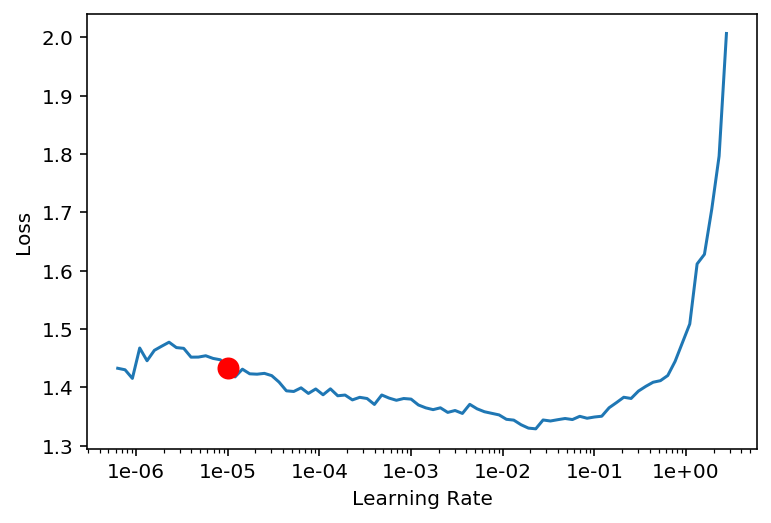

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
from fastai.callbacks import SaveModelCallback

learn.fit_one_cycle(10, callbacks=[(SaveModelCallback(learn, every='improvement', 
                                                      monitor='accuracy', name='nov27'))])

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.244549,1.085279,0.748877,0.464663,14:27
1,1.057215,0.920618,0.797803,0.587098,06:49
2,0.985028,0.906428,0.800799,0.571725,06:52
3,0.896073,0.894495,0.813280,0.617776,07:16
4,0.855543,0.860849,0.804793,0.579174,07:06
5,0.843287,0.814183,0.834249,0.689212,06:43
6,0.776644,0.778763,0.850225,0.716979,06:35
7,0.737175,0.732750,0.866700,0.755346,06:38
8,0.701477,0.728841,0.869695,0.759078,06:37
9,0.688638,0.726196,0.874189,0.778206,06:39


Better model found at epoch 0 with accuracy value: 0.748876690864563.
Better model found at epoch 1 with accuracy value: 0.7978032827377319.
Better model found at epoch 2 with accuracy value: 0.800798773765564.
Better model found at epoch 3 with accuracy value: 0.8132801055908203.
Better model found at epoch 5 with accuracy value: 0.8342486023902893.
Better model found at epoch 6 with accuracy value: 0.8502246737480164.
Better model found at epoch 7 with accuracy value: 0.8666999340057373.
Better model found at epoch 8 with accuracy value: 0.8696954846382141.
Better model found at epoch 9 with accuracy value: 0.8741887211799622.
set state called


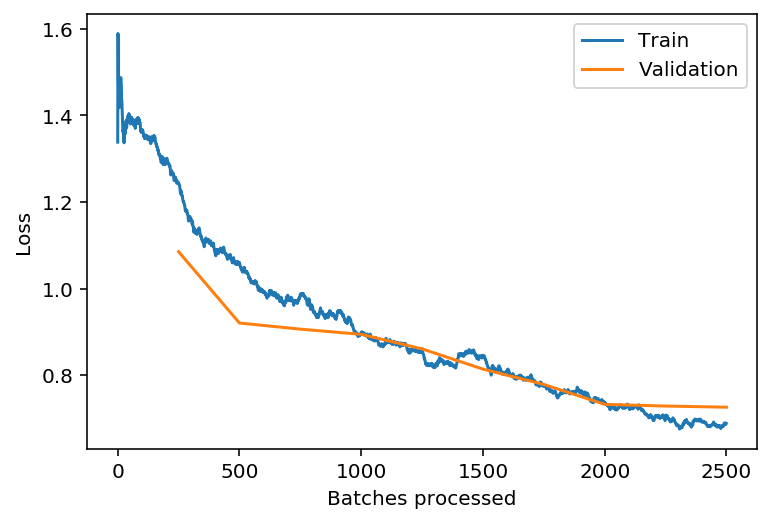

In [0]:
learn.recorder.plot_losses()

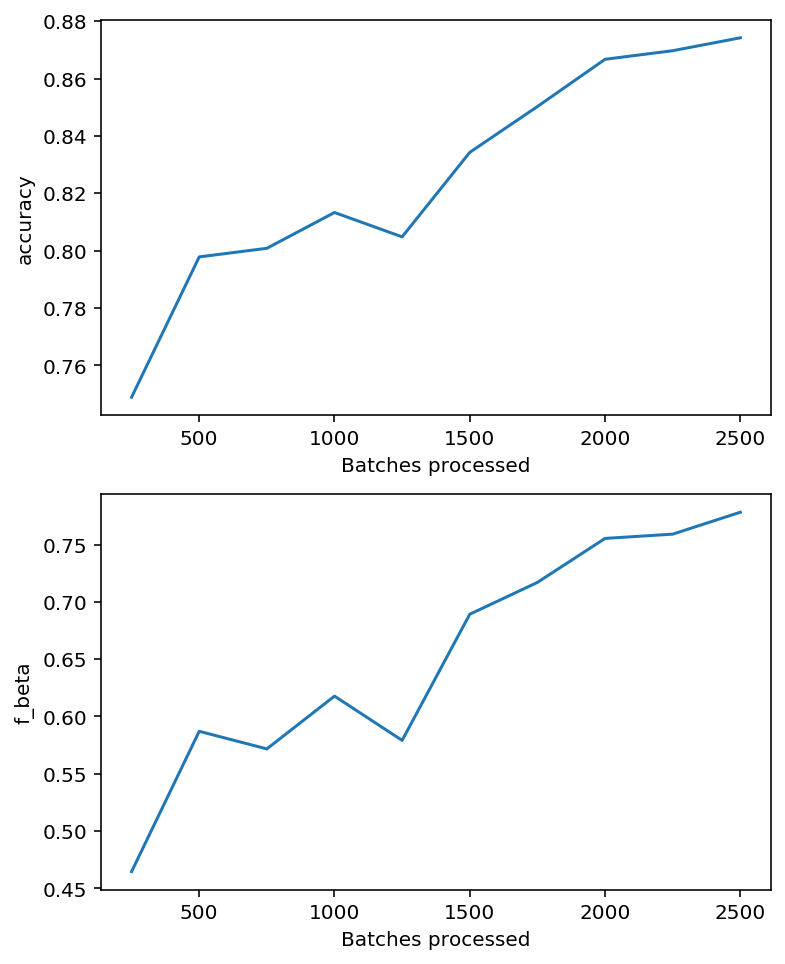

In [0]:
learn.recorder.plot_metrics()

# _Interpretation_

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

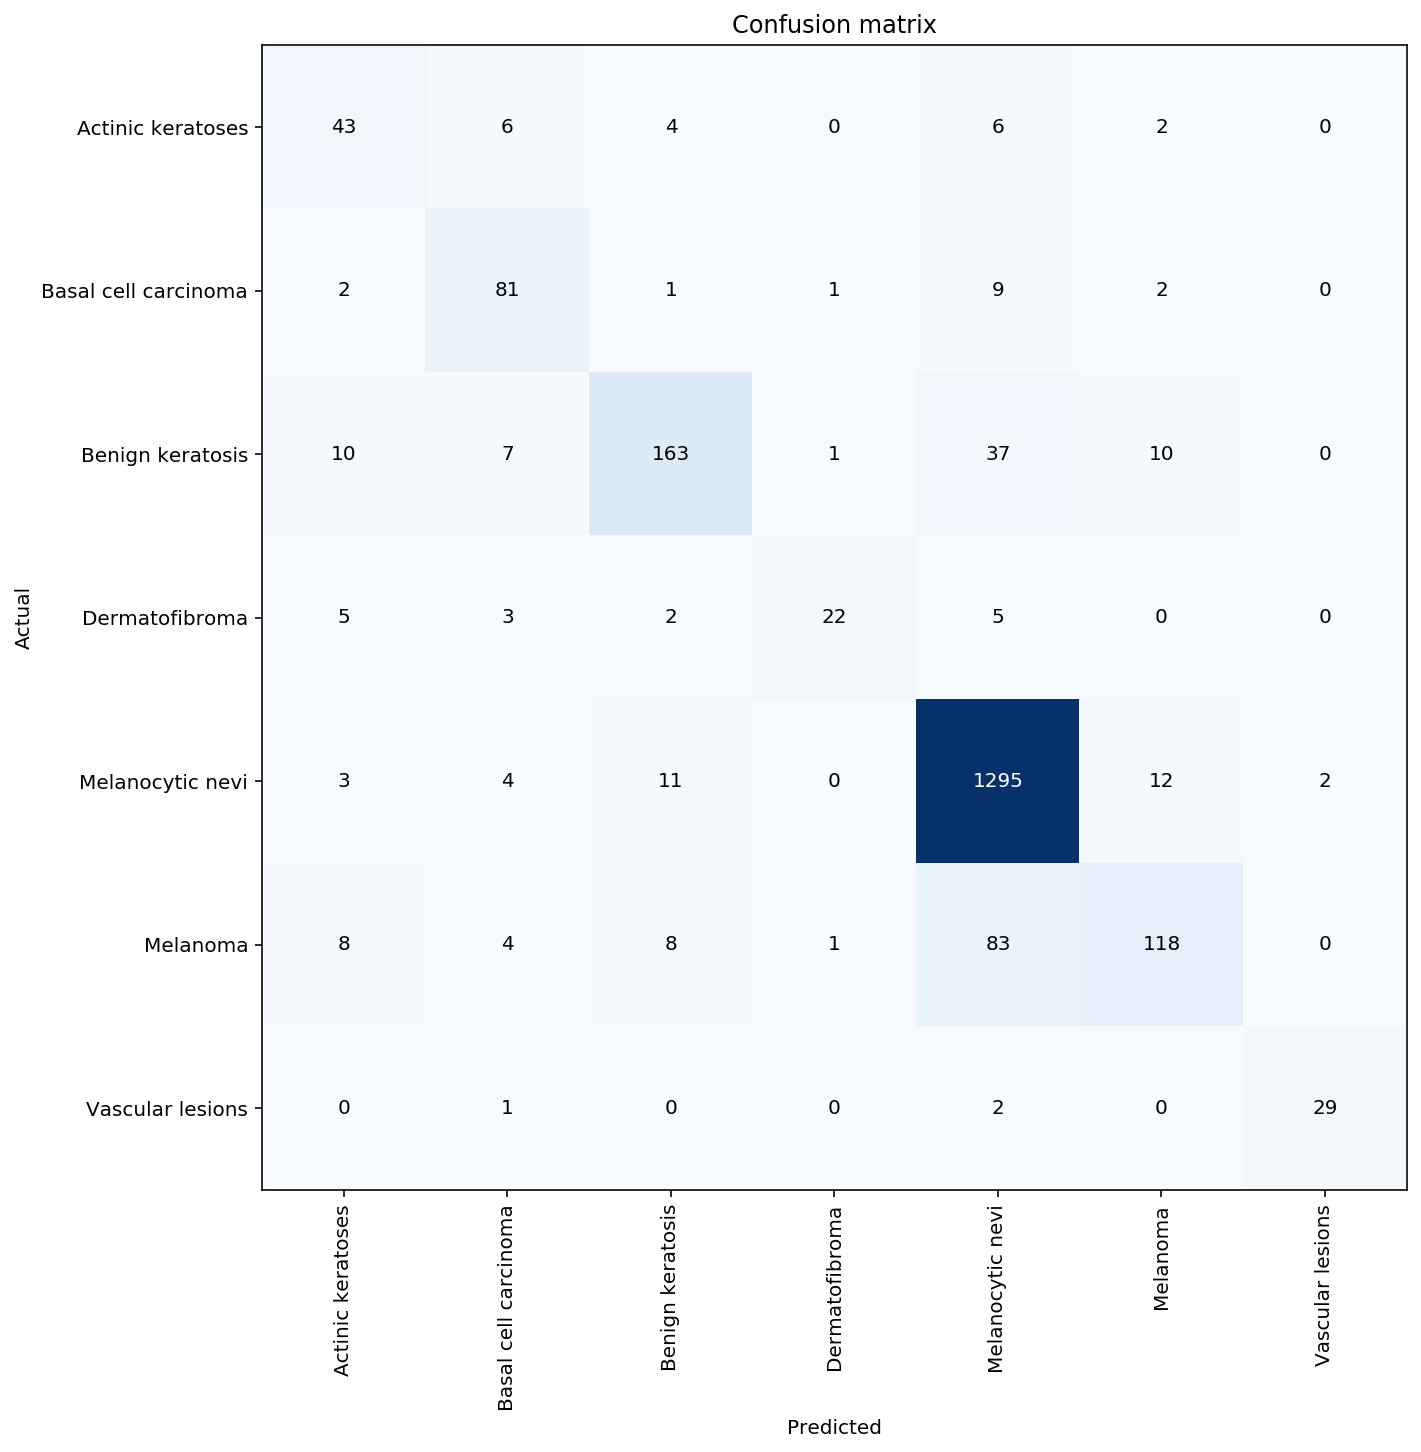

In [0]:
interp.plot_confusion_matrix(figsize=(10,10))

In [0]:
most_confused = pd.DataFrame(interp.most_confused())
most_confused.columns = ['actual', 'predicted', 'count']
most_confused[:5]

,actual,predicted,count
0,Melanoma,Melanocytic nevi,83
1,Benign keratosis,Melanocytic nevi,37
2,Melanocytic nevi,Melanoma,12
3,Melanocytic nevi,Benign keratosis,11
4,Benign keratosis,Actinic keratoses,10


# _Test: Discriminative Layer Training_

In [0]:
learn.load('nov27');

set state called


In [0]:
learn.unfreeze()

In [0]:
learn.data.batch_size = 24

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.94E-08
Min loss divided by 10: 1.17E-07


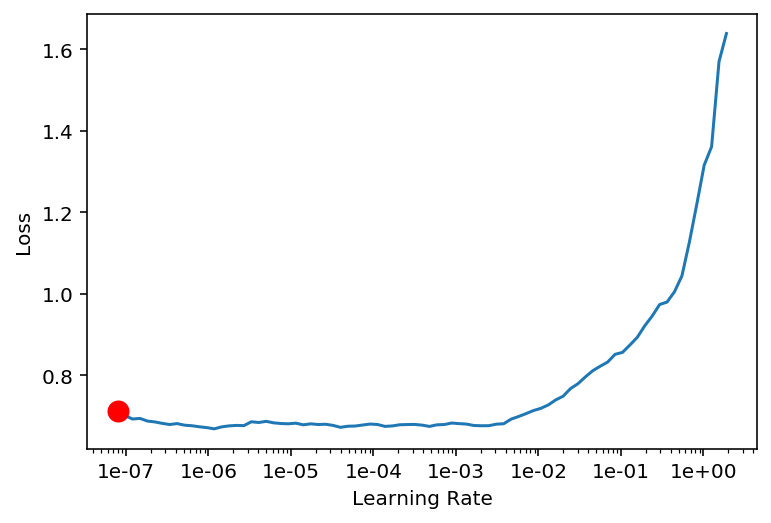

In [0]:
learn.lr_find(start_lr=1e-8, end_lr=10, num_it=100)
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4), callbacks=[(SaveModelCallback(learn, every='improvement', 
                                                                         monitor='accuracy', name='nov27-discrim'))])

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.704718,0.722032,0.879181,0.772650,06:42
1,0.704828,0.723125,0.876685,0.774338,06:55
2,0.690667,0.719892,0.877683,0.784624,06:48
3,0.700847,0.720388,0.876186,0.772574,06:46
4,0.695701,0.717092,0.877683,0.775319,06:46


Better model found at epoch 0 with accuracy value: 0.8791812062263489.
set state called
